# Subbundles Part 6: Visualization

**Subbundle** - a subgroup of streamlines with a set of common properties

In [1]:
from utils import get_tractogram_filename, get_scalar_filename

import os.path as op

import tempfile
import numpy as np

import nibabel as nib

from dipy.io.streamline import load_tractogram
from dipy.io.stateful_tractogram import StatefulTractogram
from dipy.stats.analysis import afq_profile, gaussian_weights

import seaborn as sns
import matplotlib.pyplot as plt
from dipy.viz import window, actor
from IPython.display import Image

from AFQ import api
import AFQ.data as afd

from AFQ.viz.fury_backend import visualize_volume
from AFQ.viz.fury_backend import visualize_bundles

/Users/bloomdt/anaconda/envs/subbundles/lib/python3.8/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Streamlines (from Part 2)

In [2]:
myafq = api.AFQ(
    bids_path=op.join(afd.afq_home, 'stanford_hardi'),
    dmriprep='vistasoft'
)

row = myafq.data_frame.iloc[0]

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 
/Users/bloomdt/anaconda/envs/subbundles/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [3]:
bundle_name='SLF_L'
tg_fname = tg_fname = get_tractogram_filename(myafq, bundle_name)
tractogram = load_tractogram(tg_fname, 'same')
streamlines = tractogram.streamlines
affine = tractogram.affine

## Clusters (from Part 5)

In [4]:
fa_idx = np.load('fa_idx.npy')
fa_cluster_ids = np.unique(fa_idx)
fa_clusters = np.array([np.where(fa_idx == i)[0] for i in fa_cluster_ids])
print("streamlines per cluster:", [fa_clusters[i].size for i in range(fa_clusters.size)])

gmm_fa_idx = np.load('gmm_fa_idx.npy')
gmm_fa_cluster_ids = np.unique(gmm_fa_idx)
gmm_fa_clusters = np.array([np.where(gmm_fa_idx == i)[0] for i in gmm_fa_cluster_ids])
print("streamlines per cluster:", [gmm_fa_clusters[i].size for i in range(gmm_fa_clusters.size)])

ms_fa_idx = np.load('ms_fa_idx.npy')
ms_fa_cluster_ids = np.unique(ms_fa_idx)
ms_fa_clusters = np.array([np.where(ms_fa_idx == i)[0] for i in ms_fa_cluster_ids])
print("streamlines per cluster:", [ms_fa_clusters[i].size for i in range(ms_fa_clusters.size)])




r2_idx = np.load('r2_idx.npy')
r2_cluster_ids = np.unique(r2_idx)
r2_clusters = np.array([np.where(r2_idx == i)[0] for i in r2_cluster_ids])
print("streamlines per cluster:", [r2_clusters[i].size for i in range(r2_clusters.size)])

gmm_r2_idx = np.load('gmm_r2_idx.npy')
gmm_r2_cluster_ids = np.unique(gmm_r2_idx)
gmm_r2_clusters = np.array([np.where(gmm_r2_idx == i)[0] for i in gmm_r2_cluster_ids])
print("streamlines per cluster:", [gmm_r2_clusters[i].size for i in range(gmm_r2_clusters.size)])

ms_r2_idx = np.load('ms_r2_idx.npy')
ms_r2_cluster_ids = np.unique(ms_r2_idx)
ms_r2_clusters = np.array([np.where(ms_r2_idx == i)[0] for i in ms_r2_cluster_ids])
print("streamlines per cluster:", [ms_r2_clusters[i].size for i in range(ms_r2_clusters.size)])




md_idx = np.load('md_idx.npy')
md_cluster_ids = np.unique(md_idx)
md_clusters = np.array([np.where(md_idx == i)[0] for i in md_cluster_ids])
print("streamlines per cluster:", [md_clusters[i].size for i in range(md_clusters.size)])

gmm_md_idx = np.load('gmm_md_idx.npy')
gmm_md_cluster_ids = np.unique(gmm_md_idx)
gmm_md_clusters = np.array([np.where(gmm_md_idx == i)[0] for i in gmm_md_cluster_ids])
print("streamlines per cluster:", [gmm_md_clusters[i].size for i in range(gmm_md_clusters.size)])

ms_md_idx = np.load('ms_md_idx.npy')
ms_md_cluster_ids = np.unique(ms_md_idx)
ms_md_clusters = np.array([np.where(ms_md_idx == i)[0] for i in ms_md_cluster_ids])
print("streamlines per cluster:", [ms_md_clusters[i].size for i in range(ms_md_clusters.size)])



weighted_idx = np.load('weighted_idx.npy')
weighted_cluster_ids= np.unique(weighted_idx)
weighted_clusters = np.array([np.where(weighted_idx == i)[0] for i in weighted_cluster_ids])
print("streamlines per cluster:", [weighted_clusters[i].size for i in range(weighted_clusters.size)])

gmm_weighted_idx = np.load('gmm_weighted_idx.npy')
gmm_weighted_cluster_ids= np.unique(gmm_weighted_idx)
gmm_weighted_clusters = np.array([np.where(gmm_weighted_idx == i)[0] for i in gmm_weighted_cluster_ids])
print("streamlines per cluster:", [gmm_weighted_clusters[i].size for i in range(gmm_weighted_clusters.size)])

ms_weighted_idx = np.load('ms_weighted_idx.npy')
ms_weighted_cluster_ids= np.unique(ms_weighted_idx)
ms_weighted_clusters = np.array([np.where(ms_weighted_idx == i)[0] for i in ms_weighted_cluster_ids])
print("streamlines per cluster:", [ms_weighted_clusters[i].size for i in range(ms_weighted_clusters.size)])




mdf_idx = np.load('mdf_idx.npy')
mdf_cluster_ids= np.unique(mdf_idx)
mdf_clusters = np.array([np.where(mdf_idx == i)[0] for i in mdf_cluster_ids])
print("streamlines per cluster:", [mdf_clusters[i].size for i in range(mdf_clusters.size)])

gmm_mdf_idx = np.load('gmm_mdf_idx.npy')
gmm_mdf_cluster_ids= np.unique(gmm_mdf_idx)
gmm_mdf_clusters = np.array([np.where(gmm_mdf_idx == i)[0] for i in gmm_mdf_cluster_ids])
print("streamlines per cluster:", [gmm_mdf_clusters[i].size for i in range(gmm_mdf_clusters.size)])

ms_mdf_idx = np.load('ms_mdf_idx.npy')
ms_mdf_cluster_ids= np.unique(ms_mdf_idx)
ms_mdf_clusters = np.array([np.where(ms_mdf_idx == i)[0] for i in ms_mdf_cluster_ids])
print("streamlines per cluster:", [ms_mdf_clusters[i].size for i in range(ms_mdf_clusters.size)])

streamlines per cluster: [57, 53, 355]
streamlines per cluster: [177, 88, 200]
streamlines per cluster: [385, 80]
streamlines per cluster: [37, 314, 114]
streamlines per cluster: [269, 130, 66]
streamlines per cluster: [372, 93]
streamlines per cluster: [4, 175, 286]
streamlines per cluster: [147, 105, 213]
streamlines per cluster: [455, 3, 1, 5, 1]
streamlines per cluster: [3, 338, 124]
streamlines per cluster: [244, 79, 142]
streamlines per cluster: [316, 141, 6, 1, 1]
streamlines per cluster: [16, 116, 333]
streamlines per cluster: [172, 149, 144]
streamlines per cluster: [382, 83]


## Visualize clustered streamlines

- Are there any anatomically distinct subbundles?

<span style="color:blue">**TODO: `streamtube` plots are not anatomically oriented**</span>

<span style="color:blue">**TODO: coordinate `colormap` to make subbundle identification consistent**</span>

##### FA

## ALTERNATIVELY: `fury_backend.visualize_bundles`

In [5]:
volume, color_by_volume = myafq._viz_prepare_vols(
    row,
    volume=None,
    xform_volume=False,
    color_by_volume=None,
    xform_color_by_volume=False
)

##### FA

##### MD

##### $\alpha$ FA + $\beta$ MD

#### Combine subbundles into single image

<span style="color:blue">**TODO: Color bundles bug in fury `visualize_bundles`.**</span>

INFO:AFQ.viz:Loading Volume...
INFO:AFQ.viz:Generating colorful lines from tractography...
INFO:AFQ.viz:Generating colorful lines from tractography...
INFO:AFQ.viz:Generating colorful lines from tractography...


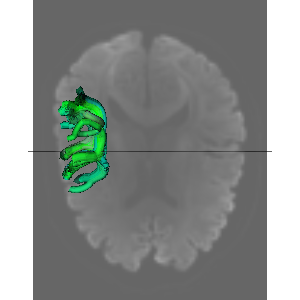

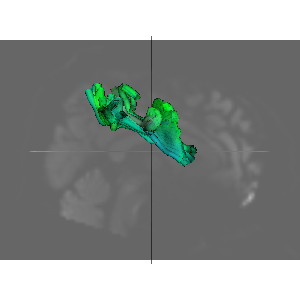

In [6]:
figure = visualize_volume(
    volume,
    interact=False,
    inline=False
)

for i in r2_cluster_ids:    
    tg = StatefulTractogram.from_sft(streamlines[r2_clusters[i-1]], tractogram)
    tg.to_vox()
    
    figure = visualize_bundles(tg, figure=figure)

fname = tempfile.NamedTemporaryFile().name + '.png'
window.snapshot(figure, fname=fname, size=(300, 300))
display(Image(fname))

figure.azimuth(270)
figure.roll(270)
fname = tempfile.NamedTemporaryFile().name + '.png'
window.snapshot(figure, fname=fname, size=(300, 300))
display(Image(fname))

<span style="color:blue">**TODO: `azimuth` hides the volume.**</span>

INFO:AFQ.viz:Loading Volume...


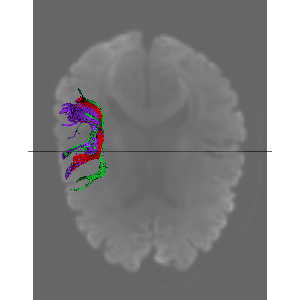

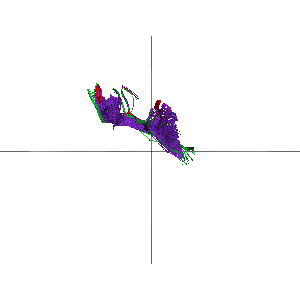

INFO:AFQ.viz:Loading Volume...


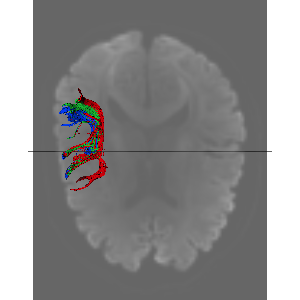

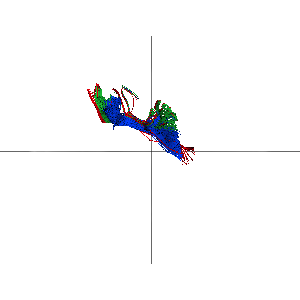

INFO:AFQ.viz:Loading Volume...


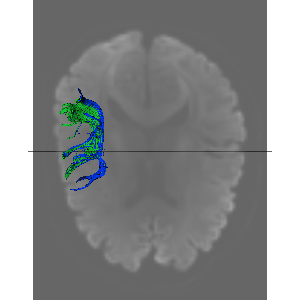

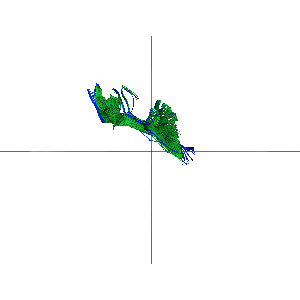

INFO:AFQ.viz:Loading Volume...


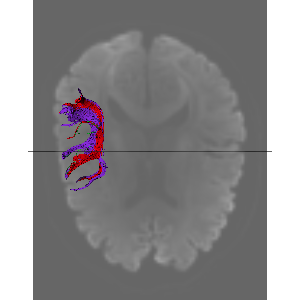

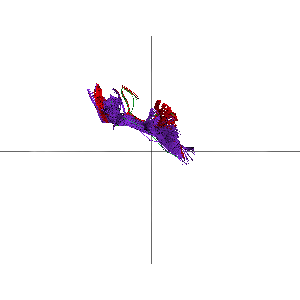

INFO:AFQ.viz:Loading Volume...


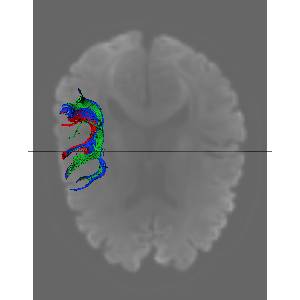

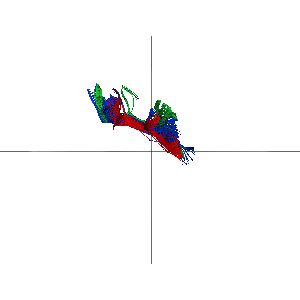

INFO:AFQ.viz:Loading Volume...


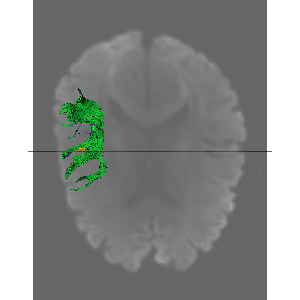

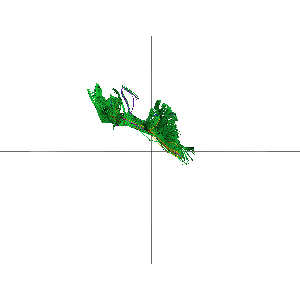

INFO:AFQ.viz:Loading Volume...


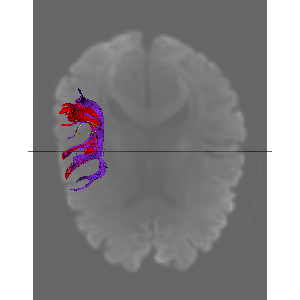

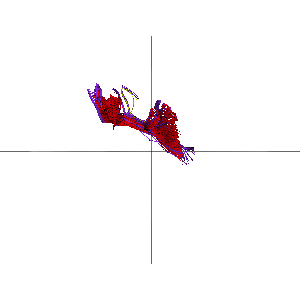

INFO:AFQ.viz:Loading Volume...


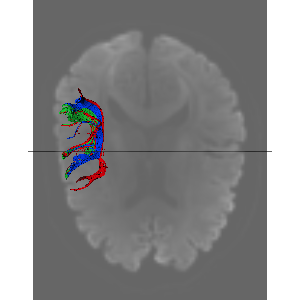

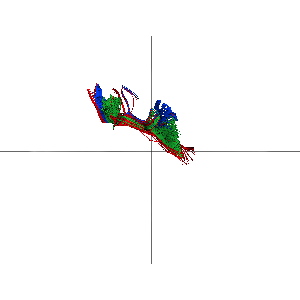

INFO:AFQ.viz:Loading Volume...


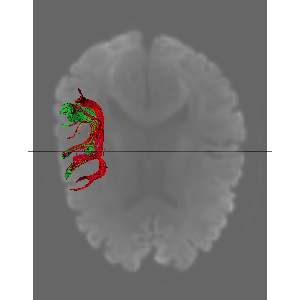

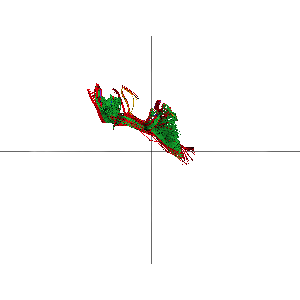

INFO:AFQ.viz:Loading Volume...


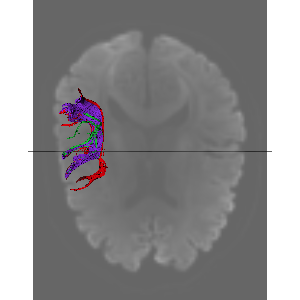

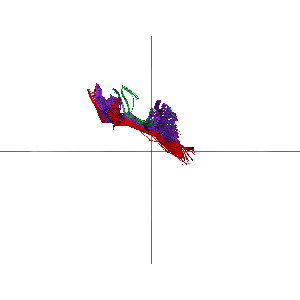

INFO:AFQ.viz:Loading Volume...


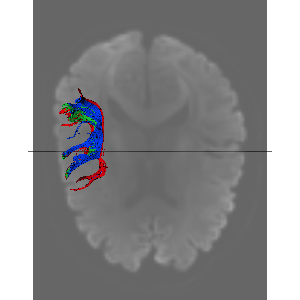

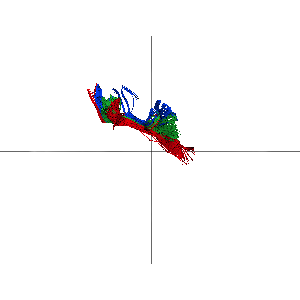

INFO:AFQ.viz:Loading Volume...


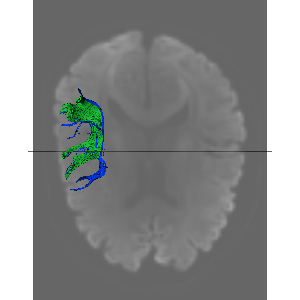

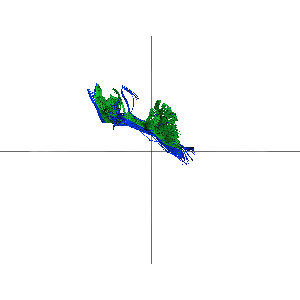

INFO:AFQ.viz:Loading Volume...


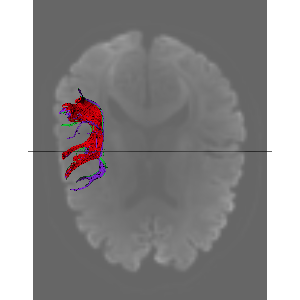

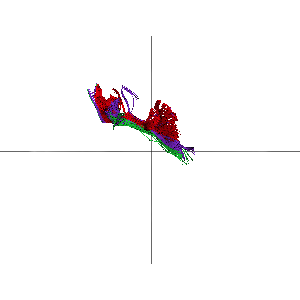

INFO:AFQ.viz:Loading Volume...


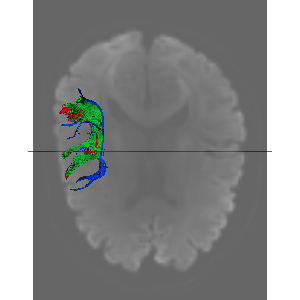

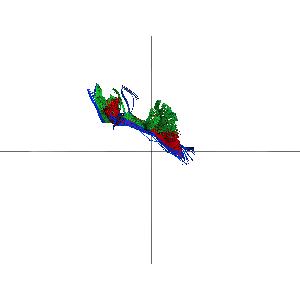

INFO:AFQ.viz:Loading Volume...


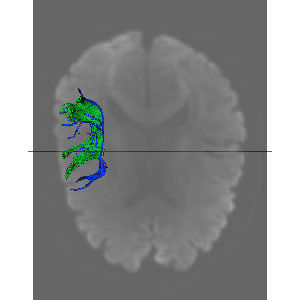

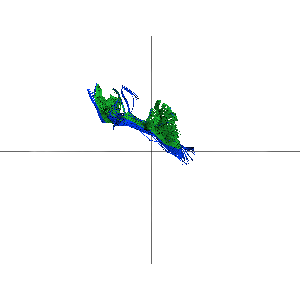

In [7]:
colors = sns.color_palette("bright6")

a = [
    fa_cluster_ids, gmm_fa_cluster_ids, ms_fa_cluster_ids,
    md_cluster_ids, gmm_md_cluster_ids, ms_md_cluster_ids,
    weighted_cluster_ids, gmm_weighted_cluster_ids, ms_weighted_cluster_ids,
    mdf_cluster_ids, gmm_mdf_cluster_ids, ms_mdf_cluster_ids,
    r2_cluster_ids, gmm_r2_cluster_ids, ms_r2_cluster_ids
]
b = [
    fa_clusters, gmm_fa_clusters, ms_fa_clusters,
    md_clusters, gmm_md_clusters, ms_md_clusters,
    weighted_clusters, gmm_weighted_clusters, ms_weighted_clusters,
    mdf_clusters, gmm_mdf_clusters, ms_mdf_clusters,
    r2_clusters, gmm_r2_clusters, ms_r2_clusters
]

for ids, idx in zip(a,b):
    figure = visualize_volume(
        volume,
        interact=False,
        inline=False
    )
    figure.SetBackground(1,1,1)

    for i in ids:    
        tg = StatefulTractogram.from_sft(streamlines[idx[i-1]], tractogram)
        tg.to_vox()

        streamline_actor = actor.streamtube(tg.streamlines, colors[i])
        figure.add(streamline_actor)

    fname = tempfile.NamedTemporaryFile().name + '.png'
    window.snapshot(figure, fname=fname, size=(300, 300))
    display(Image(fname))

    figure.azimuth(270)
    figure.roll(270)
    fname = tempfile.NamedTemporaryFile().name + '.png'
    window.snapshot(figure, fname=fname, size=(300, 300))
    display(Image(fname))

### Plot tract profiles for clusters

<span style="color:blue">**TODO: Tract profiles unstable (getting two different results).**</span>

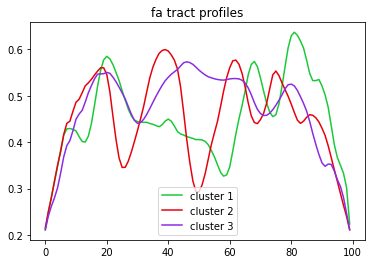

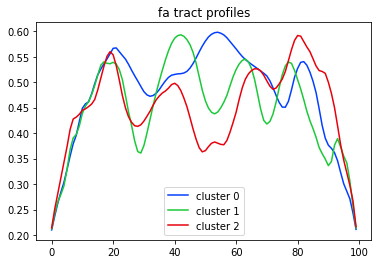

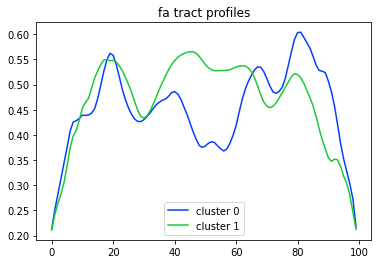

In [10]:
fa_scalar_data = nib.load(get_scalar_filename(myafq, 'DTI_FA')).get_fdata()

plt.figure()
plt.title("fa tract profiles")
for i in fa_cluster_ids:
    plt.plot(afq_profile(
        fa_scalar_data,
        streamlines[fa_clusters[i-1]],
        affine,
        weights=gaussian_weights(streamlines[fa_clusters[i-1]])
    ), color=colors[i], label=f"cluster {i}")
plt.legend()
plt.show()

plt.figure()
plt.title("fa tract profiles")
for i in gmm_fa_cluster_ids:
    plt.plot(afq_profile(
        fa_scalar_data,
        streamlines[gmm_fa_clusters[i-1]],
        affine,
        weights=gaussian_weights(streamlines[gmm_fa_clusters[i-1]])
    ), color=colors[i], label=f"cluster {i}")
plt.legend()
plt.show()

plt.figure()
plt.title("fa tract profiles")
for i in ms_fa_cluster_ids:
    plt.plot(afq_profile(
        fa_scalar_data,
        streamlines[ms_fa_clusters[i-1]],
        affine,
        weights=gaussian_weights(streamlines[ms_fa_clusters[i-1]])
    ), color=colors[i], label=f"cluster {i}")
plt.legend()
plt.show()

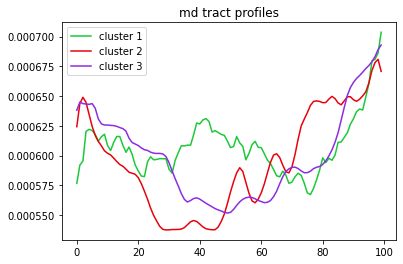

In [9]:
md_scalar_data = nib.load(get_scalar_filename(myafq, 'DTI_MD')).get_fdata()

plt.figure()
plt.title("md tract profiles")
for i in md_cluster_ids:
    plt.plot(afq_profile(
        md_scalar_data,
        streamlines[md_clusters[i-1]],
        affine,
        weights=gaussian_weights(streamlines[md_clusters[i-1]])
    ), color=colors[i], label=f"cluster {i}")
plt.legend()
plt.show()

#### Save individual subbundle tractography files